# Make Wind Sensitivity Test Figure Comparing MPAS-O and ROMS

In [1]:
import xarray as xr
import xroms
from xhistogram.xarray import histogram
import datetime
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import cmocean.cm as cmo
import numpy as np
from scipy import signal

from bichan_utils import *
from glob import glob
import time

import warnings
warnings.filterwarnings('ignore')

In [3]:
run bichan_utils_KH.py

In [ ]:
from dask.distributed import Client
client = Client()

## Load ROMS Model Outputs

In [ ]:
# Load in sensitivity files

files = [
         'roms_channel/wind_stress_0.001/',
         'roms_channel/wind_stress_0.005/',
         'roms_channel/wind_stress_0.01/',
         'roms_channel/wind_stress_0.02/',
         'roms_channel/wind_stress_0.03/',
         'roms_channel/wind_stress_0.04/',
         'roms_channel/wind_stress_0.05/',
         'roms_channel/wind_stress_0.06/',
         'roms_channel/wind_stress_0.07/',
         'roms_channel/wind_stress_0.08/',
         'roms_channel/wind_stress_0.09/',
         'roms_channel/wind_stress_0.1/',
         'roms_channel/wind_stress_0.2/',
         'roms_channel/wind_stress_0.3/',
         'roms_channel/wind_stress_0.4/',
         'roms_channel/wind_stress_0.5/',    
         'roms_channel/wind_stress_0.6/',    
         'roms_channel/wind_stress_0.7/',    
         'roms_channel/wind_stress_0.8/',
         'roms_channel/wind_stress_0.9/',
         'roms_channel/wind_stress_1.0/',
         'roms_channel/wind_stress_2.0/',
         'roms_channel/wind_stress_3.0/',
         'roms_channel/wind_stress_4.0/',
         'roms_channel/wind_stress_5.0/',
]

dss = []
for file in files:
    ds = xr.open_dataset(file+'roms_his.nc', chunks={'ocean_time': 1})
    ds, grid = xroms.roms_dataset(ds)
    ds = add_derivatives_KH(ds, grid)
    speed = xroms.speed(ds.u, ds.v, grid)
    KE = xroms.KE(ds.rho0, speed)
    ds['ke'] = KE
    ds = ds.isel(s_rho=-1)
    dss.append(ds)

In [ ]:
### Calculate ROMS Histogram Metrics

grads_bins = np.linspace(-11, -4, 71)

tslice = slice(120, 240)
yslice = slice(50, 250)
rh_dA = []
rsustrs = []
for ds in dss:
    rh_dA.append(
        histogram(np.log10(ds.gradq2.isel(ocean_time=tslice, 
                               eta_rho=yslice
                               )), 
           bins=[grads_bins]).compute()
    )
    sustr_val = ds.sustr.isel(xi_u=50, eta_rho=50).max().values
    rsustrs.append(sustr_val)
    print(np.round(sustr_val, 4))
    
rsustrs = [np.round(v, 4) for v in rsustrs]

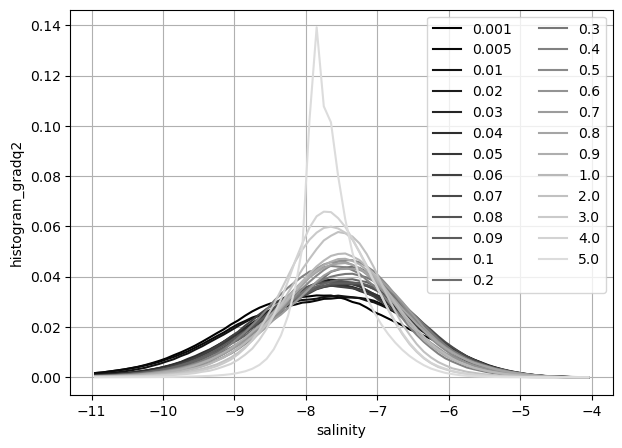

In [ ]:
### Example ROMS Histogram plot

fig = plt.figure(figsize=(7, 5))
m = len(files)
for i, h in enumerate(rh_dA):
    hnorm = h / h.sum()
    hnorm.plot(color=str((0.9*i)/m))

plt.grid(True)
plt.legend(rsustrs, ncol=2, loc=1)

## Load MPAS-O Model Outputs

In [8]:
# Load in new sensitivity files

mroots = [
         'mpaso_channel/wind_tests/wind_stress_0.000/',
         'mpaso_channel/wind_tests/wind_stress_0.001/',
         'mpaso_channel/wind_tests/wind_stress_0.005/',
         'mpaso_channel/wind_tests/wind_stress_0.010/',
         'mpaso_channel/wind_tests/wind_stress_0.020/',
         'mpaso_channel/wind_tests/wind_stress_0.030/',
         'mpaso_channel/wind_tests/wind_stress_0.040/',
         'mpaso_channel/wind_tests/wind_stress_0.050/',
         'mpaso_channel/wind_tests/wind_stress_0.060/',
         'mpaso_channel/wind_tests/wind_stress_0.070/',
         'mpaso_channel/wind_tests/wind_stress_0.080/',
         'mpaso_channel/wind_tests/wind_stress_0.090/',
         'mpaso_channel/wind_tests/wind_stress_0.100/',
         'mpaso_channel/wind_tests/wind_stress_0.200/',
         'mpaso_channel/wind_tests/wind_stress_0.300/',
         'mpaso_channel/wind_tests/wind_stress_0.400/',
         'mpaso_channel/wind_tests/wind_stress_0.500/',
         'mpaso_channel/wind_tests/wind_stress_0.600/',
         'mpaso_channel/wind_tests/wind_stress_0.700/',
         'mpaso_channel/wind_tests/wind_stress_0.800/',
         'mpaso_channel/wind_tests/wind_stress_0.900/',
         'mpaso_channel/wind_tests/wind_stress_1.000/',
         'mpaso_channel/wind_tests/wind_stress_2.000/',
         'mpaso_channel/wind_tests/wind_stress_3.000/',
         'mpaso_channel/wind_tests/wind_stress_4.000/',
         'mpaso_channel/wind_tests/wind_stress_5.000/'
]

mds = []
mdsg = []
for rootdir in mroots:
    ds_mpas = xr.open_dataset(rootdir + 'output.nc', chunks={'Time': 1})
    dsg = xr.open_dataset(rootdir + 'channel_init.nc')
    ds_mpas['normalizedRelativeVorticity'] = ds_mpas.relativeVorticityCell / dsg.fCell
    ds_mpas['normalizedDivergence'] = ds_mpas.divergence / dsg.fCell
    mds.append(ds_mpas)
    mdsg.append(dsg)


In [13]:
# Calculate total strain from MPAS outputs with velocity gradients
# Add in additional gradient calculations as well (modified from bichan_utils.py)

mds_vel = []
ictr = 0

for ds in mds:
    ##################################
    # Add Coriolis term to output file for simplicity of below equations
    ds['f'] = np.unique(mdsg[ictr].fCell.values)
    
    ##################################
    # Add strain
    ds['alpha'] = ( np.sqrt( (ds.dUdx_cell-ds.dVdy_cell)**2 + (ds.dVdx_cell+ds.dUdy_cell)**2 ) 
              ) / ds.f.values
    ds['alpha'].name = 'Normalized total strain'
    
    ##################################
    # Principle deformation components

    ds['lminor'] = 0.5 * (ds.normalizedDivergence - ds.alpha)
    ds['lminor'].name = 'lambda minor'

    ds['lmajor'] = 0.5 * (ds.normalizedDivergence + ds.alpha)
    ds['lmajor'].name = 'lambda major'    
    ##################################
    # Along- and cross-frontal velocity gradients
    
    # angle is wrt x, so need to do arctan2(y, x)
    ds['phi_cf'] = np.arctan2(ds.dSdy_cell, ds.dSdx_cell)
    ds['phi_af'] = ds.phi_cf + np.pi/2.0

    ds['du_cf'] = ( ds.dUdx_cell*np.cos(ds.phi_cf)**2 + ds.dVdy_cell*np.sin(ds.phi_cf)**2 
               + (ds.dUdy_cell + ds.dVdx_cell)*np.sin(ds.phi_cf)*np.cos(ds.phi_cf) )/ds.f.values

    ds['du_af'] = ( ds.dUdx_cell*np.cos(ds.phi_af)**2 + ds.dVdy_cell*np.sin(ds.phi_af)**2
              + (ds.dUdy_cell + ds.dVdx_cell)*np.sin(ds.phi_af)*np.cos(ds.phi_af) )/ds.f.values
    
    ##################################
    # The frontogenesis function
    
    # Dimensional frontogenesis function
    Dgradq_i = - ds.dUdx_cell*ds.dSdx_cell - ds.dVdx_cell*ds.dSdy_cell
    Dgradq_j = - ds.dUdy_cell*ds.dSdx_cell - ds.dVdy_cell*ds.dSdy_cell
    ds['Ddelq2'] = (ds.dSdx_cell*Dgradq_i + ds.dSdy_cell*Dgradq_j)
    ds['Ddelq2'].name = 'Frontogenesis function'

    # Density gradients squared
    ds['gradq2'] = ds.dSdx_cell**2 + ds.dSdy_cell**2
    ds['gradq2'].name = r'$(\nabla q)^2$'

    # Normalized frontogenesis function
    ds['nFGF'] = 0.5 * ds.Ddelq2 / (ds.gradq2 * ds.f.values)
    ds['nFGF'].name = r'Normalized Frontogenesis Function'    
    
    ##################################
    ictr+=1
    
    mds_vel.append(ds)

In [ ]:
### Calculate MPAS-O Histogram Metrics

mgrads_bins = np.linspace(-11, -4, 71)
t1 = int(10*12)
t2 = int(20*12)

mh_dA = []
sustrs = []
i = 0
for ds in mds_vel:
    ympas = mdsg[i].yCell.values
    idx = np.where(np.logical_and(ympas>50e3, ympas<250e3))
    dAmx = mdsg[i].areaCell[idx[0][0]:idx[0][-1]]
    mh_dA.append(
        histogram(np.log10(ds.gradq2.isel(
                            Time=slice(t1, t2),
                            nCells=slice(idx[0][0],idx[0][-1]),
                            nVertLevels=0)),
                    weights=dAmx,
                    bins=[mgrads_bins]).compute()
    )

    i+=1
    
msustrs = []

for mri in mroots:
    sgrab = mri.split('_')[-1]
    msustrs.append(sgrab[0:5])

msustrs = msustrs[1::]

zero_mpas = mh_dA[0] # No wind condition
mh_dA = mh_dA[1::] # All wind sensitivity tests

# MPAS surface stress values for plotting later
msus_plot = []
for j in msustrs:
    msus_plot.append(float(j))

Text(0.5, 1.0, 'MPAS-O Wind Tests')

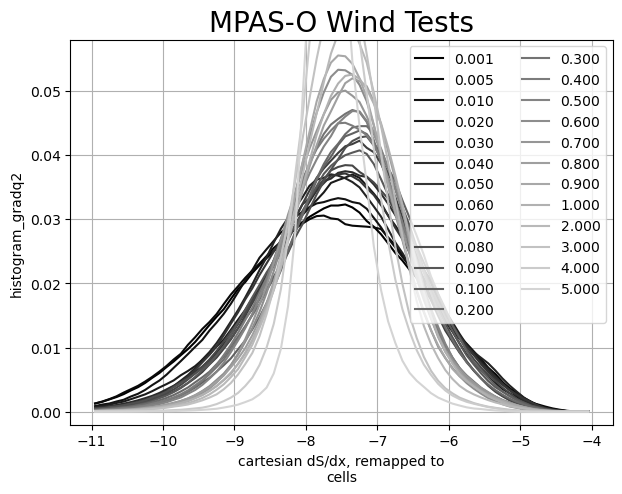

In [21]:
### Example MPAS-O Histogram Plot

fig = plt.figure(figsize=(7, 5))
m = len(mroots)
for i, h in enumerate(mh_dA):
    hnorm = h / h.sum()
    hnorm.plot(color=str((0.9*i)/m))

plt.grid(True)
plt.legend(msustrs, ncol=2, loc=1)
plt.ylim([-0.002, 0.058])
plt.title('MPAS-O Wind Tests', fontsize=20)

In [22]:
grads_bins = np.linspace(-11, -4, 71)

gradsc = 0.5*(grads_bins[:-1] + grads_bins[1:])
mpas_nowind = float(np.sum(zero_mpas*gradsc)/np.sum(zero_mpas))

Text(0.5, 1.0, 'MPAS-O Wind Tests')

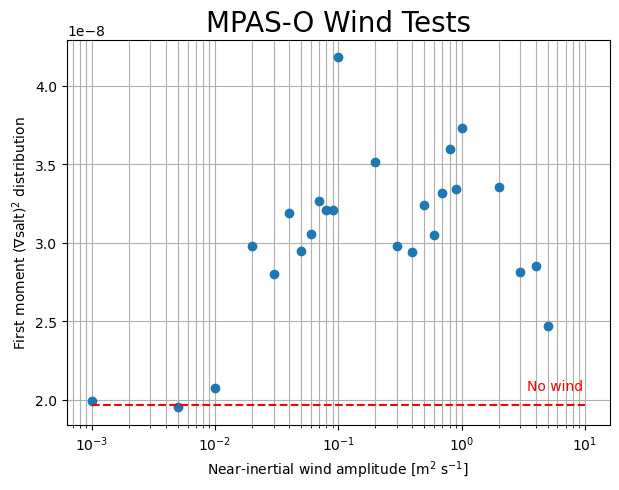

In [38]:
fig = plt.figure(figsize=(7, 5))

grad_max = [float(np.sum(h*gradsc)/np.sum(h)) for h in mh_dA]
plt.semilogx(msus_plot, 10**(np.asarray(grad_max)), 'o')
plt.plot([1e-3, 10], 10**(np.asarray([mpas_nowind, mpas_nowind])), '--r')
plt.text(0.9, .10, 'No wind', color='r', 
         horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes)
plt.ylabel(r'First moment $(\nabla$salt$)^2$ distribution')
plt.xlabel(r'Near-inertial wind amplitude [m$^2$ s$^{-1}$]')
plt.grid(which='both')
plt.title('MPAS-O Wind Tests', fontsize=20)

## Make combined figure

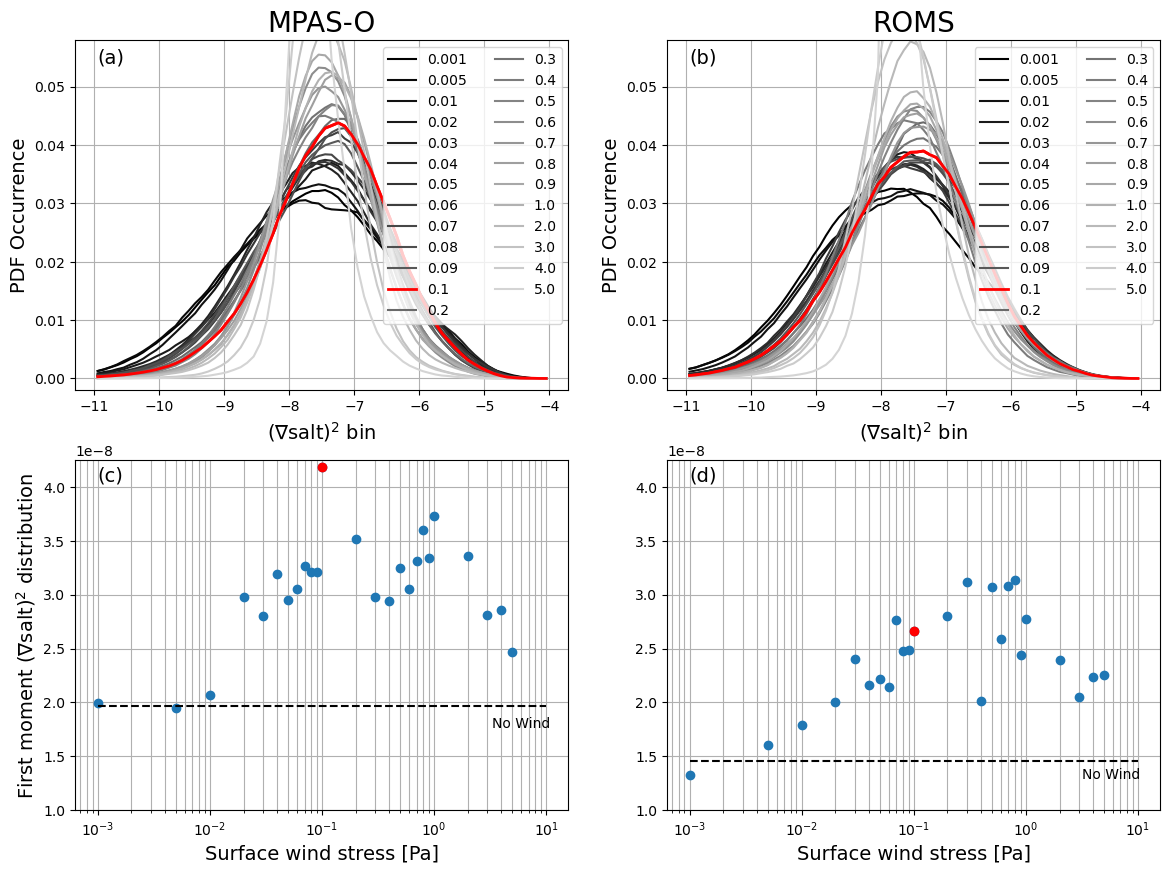

In [52]:
fig, axs = plt.subplots(2, 2, figsize=(14, 10))

subsel = [0, 2, 4, 6, 0, 2, 4, 6] # Select 4 resolutions for plots
raxi = 0
sublab = ['(a)', '(b)', '(c)', '(d)']

######################################################
# MPAS-O Histograms
######################################################
ax = axs[0,0]

mlen = len(mroots)
for i, h in enumerate(mh_dA):
    hnorm = h / h.sum()
    if i==11:
        hnorm.plot(color='r', ax=ax, linewidth=2)
    else:
        hnorm.plot(color=str((0.9*i)/mlen), ax=ax)
rhnorm = mh_dA[11] / mh_dA[11].sum()
rhnorm.plot(color='r', ax=ax, linewidth=2, label='_Hidden Figure')

ax.grid(True)
ax.legend(rsustrs, ncol=2, loc=1)
ax.set_ylim([-0.002, 0.058])
ax.set_title('MPAS-O', fontsize=20)
ax.set_ylabel('PDF Occurrence', fontsize=14)
ax.set_xlabel(r'$(\nabla$salt$)^2$ bin', fontsize=14)
ax.text(-10.95, 0.054, sublab[raxi], size=14)  # , bbox=dict(facecolor='1', edgecolor='k', pad=3.0),
raxi+=1

######################################################
# ROMS Histograms
######################################################
ax = axs[0,1]

rlen = len(files)
for i, h in enumerate(rh_dA):
    hnorm = h / h.sum()
    if i==11:
        hnorm.plot(color='r', ax=ax, linewidth=2)
    else:
        hnorm.plot(color=str((0.9*i)/mlen), ax=ax)
rhnorm = rh_dA[11] / rh_dA[11].sum()
rhnorm.plot(color='r', ax=ax, linewidth=2, label='_Hidden Figure')

ax.grid(True)
ax.legend(rsustrs, ncol=2, loc=1)
ax.set_ylim([-0.002, 0.058])
ax.set_title('ROMS', fontsize=20)
ax.set_ylabel('PDF Occurrence', fontsize=14)
ax.set_xlabel(r'$(\nabla$salt$)^2$ bin', fontsize=14)
ax.text(-10.95, 0.054, sublab[raxi], size=14)  # , bbox=dict(facecolor='1', edgecolor='k', pad=3.0),
raxi+=1

######################################################
# MPAS-O Scatterplot
######################################################
ax = axs[1,0]

gradsc = 0.5*(grads_bins[:-1] + grads_bins[1:])
grad_max = [float(np.sum(h*gradsc)/np.sum(h)) for h in mh_dA]
ax.semilogx(msus_plot, 10**(np.asarray(grad_max)), 'o')
ax.semilogx(msus_plot[11], 10**(np.asarray(grad_max[11])), 'ro')
ax.plot([1e-3, 10], 10**(np.asarray([mpas_nowind, mpas_nowind])), '--k')
ax.text(6, 1.8E-8, 'No Wind', color='k', horizontalalignment='center', verticalalignment='center')
ax.set_ylabel(r'First moment $(\nabla$salt$)^2$ distribution', fontsize=14)
ax.set_xlabel(r'Surface wind stress [Pa]', fontsize=14)
ax.grid(which='both')
ax.set_ylim([1.0E-8, 4.25E-8])
ax.text(1E-3, 4.05E-8, sublab[raxi], size=14)  # , bbox=dict(facecolor='1', edgecolor='k', pad=3.0),
raxi+=1

######################################################
# ROMS Scatterplot
######################################################
ax = axs[1,1]

gradsc = 0.5*(grads_bins[:-1] + grads_bins[1:])
grad_max = [float(np.sum(h*gradsc)/np.sum(h)) for h in rh_dA]
ax.semilogx(rsustrs, 10**(np.asarray(grad_max)), 'o')
ax.semilogx(rsustrs[11], 10**(np.asarray(grad_max[11])), 'ro')
ax.plot([1e-3, 10], 10**(np.asarray([-7.83705333961882, -7.83705333961882])), '--k')
ax.text(0.9, .10, 'No Wind', color='k', 
         horizontalalignment='center',
         verticalalignment='center', transform=plt.gca().transAxes)
ax.set_xlabel(r'Surface wind stress [Pa]', fontsize=14)
ax.grid(which='both')
ax.set_ylim([1.0E-8, 4.25E-8])
ax.text(1E-3, 4.05E-8, sublab[raxi], size=14) 
raxi+=1
